# SIT 720 MACHINE LEARNING

## Microclimate Sensors Data Cleaning & Preprocessing

**Author:** Bhuvan Purushothaman Subramani  
**Student ID:** 224113776  
**Email:** s224113776@deakin.edu.au

This project involves cleaning and preparing the Microclimate Sensors dataset for further analysis and machine learning tasks. It includes handling missing data, encoding geospatial features, and normalizing continuous variables to ensure data quality and model readiness.

---

In [39]:
# Import pandas and numpy for data manipulation and analysis
import pandas as pd
import numpy as np

# Import matplotlib for basic plotting
import matplotlib.pyplot as plt

# Import seaborn for advanced statistical data visualization
import seaborn as sns

# Import MinMaxScaler for scaling continuous numeric features to a 0–1 range
from sklearn.preprocessing import MinMaxScaler


In [40]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv("microclimate-sensors-data.csv")

# Calculate the number of missing (null) entries for each column
missing_entries = df.isnull().sum()

# Print the column name along with its corresponding count of missing entries
for col, count in missing_entries.items():
    print(f"{col}: {count} missing entries")


Device_id: 0 missing entries
Time: 0 missing entries
SensorLocation: 6143 missing entries
LatLong: 11483 missing entries
MinimumWindDirection: 40111 missing entries
AverageWindDirection: 504 missing entries
MaximumWindDirection: 40269 missing entries
MinimumWindSpeed: 40269 missing entries
AverageWindSpeed: 504 missing entries
GustWindSpeed: 40269 missing entries
AirTemperature: 504 missing entries
RelativeHumidity: 504 missing entries
AtmosphericPressure: 504 missing entries
PM25: 19039 missing entries
PM10: 19039 missing entries
Noise: 19039 missing entries


In [41]:
# Create a copy of the original DataFrame to avoid modifying the original data
df_new = df.copy()

# Create a mapping of SensorLocation to the first available LatLong value
# This is used to fill missing LatLong values based on SensorLocation
locToLatlongMap = (
    df[df['LatLong'].notnull()]                 # Filter rows where LatLong is not null
    .groupby('SensorLocation')['LatLong']       # Group by SensorLocation
    .first()                                    # Take the first LatLong for each location
    .to_dict()                                  # Convert the result to a dictionary
)


# Identify rows where both SensorLocation and LatLong are missing
rows_to_drop = df_new['SensorLocation'].isnull() & df_new['LatLong'].isnull()

# Drop those rows from the DataFrame and create a cleaned copy
df_cleaned = df_new[~rows_to_drop].copy()


print(f"Number of rows with missing LatLong before filling: {df_cleaned['LatLong'].isnull().sum()}")

# Fill missing LatLong values using the mapping based on SensorLocation
df_cleaned['LatLong'] = df_cleaned.apply(
    lambda row: locToLatlongMap[row['SensorLocation']] if pd.isnull(row['LatLong']) else row['LatLong'],
    axis=1
)

print(f"Number of rows with missing LatLong after filling: {df_cleaned['LatLong'].isnull().sum()}")


# Recalculate and print the number of missing entries for each column
missing_entries = df_cleaned.isnull().sum()
for col, count in missing_entries.items():
    print(f"{col}: {count} missing entries")


Number of rows with missing LatLong before filling: 5340
Number of rows with missing LatLong after filling: 0
Device_id: 0 missing entries
Time: 0 missing entries
SensorLocation: 0 missing entries
LatLong: 0 missing entries
MinimumWindDirection: 39852 missing entries
AverageWindDirection: 352 missing entries
MaximumWindDirection: 40010 missing entries
MinimumWindSpeed: 40010 missing entries
AverageWindSpeed: 352 missing entries
GustWindSpeed: 40010 missing entries
AirTemperature: 352 missing entries
RelativeHumidity: 352 missing entries
AtmosphericPressure: 352 missing entries
PM25: 18839 missing entries
PM10: 18839 missing entries
Noise: 18839 missing entries


In [42]:
# List of numeric columns where missing values need to be handled
numeric_cols = [
    'MinimumWindDirection', 'AverageWindDirection', 'MaximumWindDirection',
    'MinimumWindSpeed', 'AverageWindSpeed', 'GustWindSpeed',
    'AirTemperature', 'RelativeHumidity', 'AtmosphericPressure',
    'PM25', 'PM10', 'Noise'
]

# Dictionary to store which method (mean or median) was used and the value filled for each column
replacement_log = {}

# Loop through each numeric column to check and impute missing values
for col in numeric_cols:
    # Check if there are any missing values in the column
    if df_cleaned[col].isnull().sum() > 0:
        # Calculate the skewness of the column
        skewness = df_cleaned[col].skew()

        # Decide whether to use mean or median based on skewness
        method = 'median' if abs(skewness) > 1 else 'mean'

        # Compute the replacement value accordingly
        replacement_value = df_cleaned[col].median() if method == 'median' else df_cleaned[col].mean()

        # Fill missing values — using assignment method for future compatibility (not inplace)
        df_cleaned[col] = df_cleaned[col].fillna(replacement_value)

        # Log the method and value used for this column
        replacement_log[col] = (method, replacement_value)

# Display count of missing values after imputation
print("\nMissing values after imputation:")
print(df_cleaned[numeric_cols].isnull().sum())

# Display which method and value were used for each column
print("\nImputation method and values used:")
for col, (method, val) in replacement_log.items():
    print(f"{col}: filled using {method} with value {val:.2f}")



Missing values after imputation:
MinimumWindDirection    0
AverageWindDirection    0
MaximumWindDirection    0
MinimumWindSpeed        0
AverageWindSpeed        0
GustWindSpeed           0
AirTemperature          0
RelativeHumidity        0
AtmosphericPressure     0
PM25                    0
PM10                    0
Noise                   0
dtype: int64

Imputation method and values used:
MinimumWindDirection: filled using median with value 0.00
AverageWindDirection: filled using mean with value 165.71
MaximumWindDirection: filled using median with value 353.00
MinimumWindSpeed: filled using median with value 0.00
AverageWindSpeed: filled using median with value 0.80
GustWindSpeed: filled using median with value 2.80
AirTemperature: filled using mean with value 16.32
RelativeHumidity: filled using mean with value 66.59
AtmosphericPressure: filled using median with value 1014.60
PM25: filled using median with value 3.00
PM10: filled using median with value 5.00
Noise: filled using me

### Filling Missing Entries Using Mean or Median

To handle missing values in numerical features, we fill them using either the **mean** or **median** of the observed values. The choice between mean and median depends on the distribution of the data:

- **Mean** is suitable when the feature's data is approximately symmetric and free of extreme outliers. It represents the average value of the data.

- **Median** is preferred when the feature's data is skewed or contains outliers because it is less affected by extreme values and better represents the typical value.

#### Approach:

1. Calculate the **skewness** of each feature's observed data.
2. If the absolute skewness is greater than 1 (indicating strong skew), use the **median** to fill missing entries.
3. Otherwise, use the **mean**.

This method ensures that the imputed values are representative of the feature’s true distribution, leading to more reliable and unbiased data for analysis and modeling.


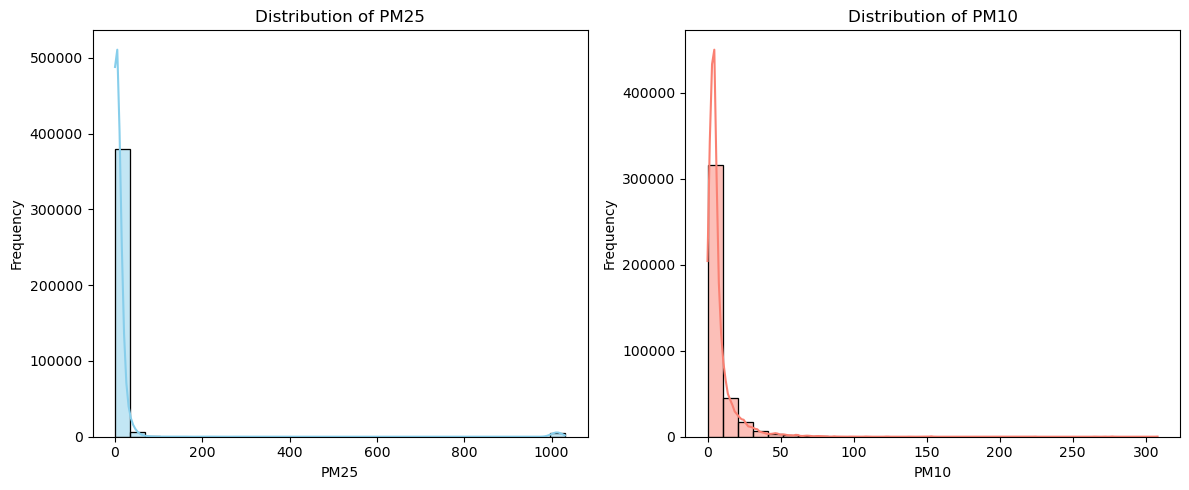

Correlation between PM25 and PM10: 0.05


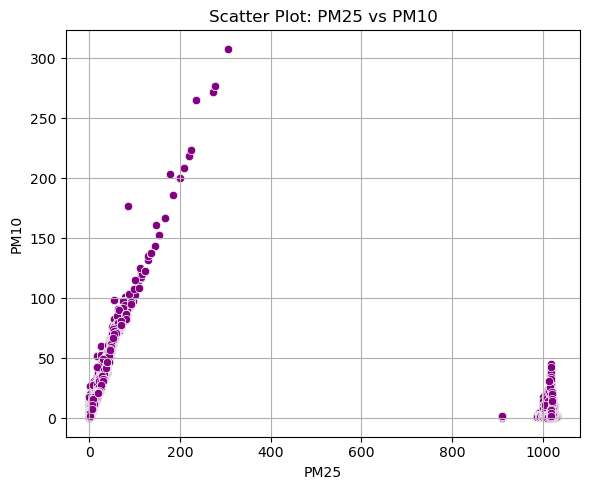

In [43]:

# Plot histograms of PM25 and PM10
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['PM25'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of PM25')
plt.xlabel('PM25')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['PM10'], bins=30, kde=True, color='salmon')
plt.title('Distribution of PM10')
plt.xlabel('PM10')
plt.ylabel('Frequency')

plt.tight_layout()  
plt.show()

# Calculate correlation
correlation = df_cleaned['PM25'].corr(df_cleaned['PM10'])
print(f"Correlation between PM25 and PM10: {correlation:.2f}")

# Scatter plot to visually assess the correlation
plt.figure(figsize=(6, 5))
sns.scatterplot(x='PM25', y='PM10', data=df_cleaned, color='purple')
plt.title('Scatter Plot: PM25 vs PM10')
plt.xlabel('PM25')
plt.ylabel('PM10')
plt.grid(True)
plt.tight_layout()
plt.show()


### Correlation Analysis between PM25 and PM10

- The calculated correlation coefficient between **PM25** and **PM10** is **0.05**, suggesting a **very weak linear relationship**.
- However, this result is **misleading**.

#### Reason:
- The **histograms clearly show the presence of extreme outliers** in PM2.5 values.
- These outliers distort the overall correlation, masking the true underlying relationship between the two variables.
- Normally, PM25 (fine particles) is a component of PM10 (coarse particles), and a **strong positive correlation is expected** under clean data conditions.

> Conclusion: The low correlation is primarily due to **outliers**, not an actual lack of relationship. Removing or treating outliers will likely reveal a stronger correlation.


In [44]:
# --- Split 'LatLong' into 'Latitude' and 'Longitude' ---
# Split the 'LatLong' string by comma into two new columns
df_cleaned[['Latitude', 'Longitude']] = df_cleaned['LatLong'].str.split(',', expand=True)

# Convert the new columns from string to float
df_cleaned['Latitude'] = df_cleaned['Latitude'].astype(float)
df_cleaned['Longitude'] = df_cleaned['Longitude'].astype(float)

# Display a few rows to confirm
print(df_cleaned[['Latitude', 'Longitude']].head())


    Latitude   Longitude
0 -37.812860  144.974539
1 -37.819499  144.978721
2 -37.818593  144.971640
3 -37.818452  144.967847
4 -37.822234  144.982941


### Encoding Approach Explanation

The variable `LatLong` contains continuous spatial coordinate data in the form `"Latitude,Longitude"`.  
We split this string into two separate numeric features: `Latitude` and `Longitude`.

This approach is appropriate because:
- The coordinates are naturally numeric and continuous.
- Retaining their numerical format enables spatial analysis, clustering, distance calculations, and better integration into machine learning models.

**Why not use categorical encoding?**  
Categorical techniques like one-hot or label encoding are not suitable for `LatLong` because they would:
- Lose the inherent ordering and spatial relationships between coordinates.
- Create an unnecessarily high-dimensional space with no added benefit.

By keeping `Latitude` and `Longitude` as numeric features, we preserve valuable geospatial context in the dataset.


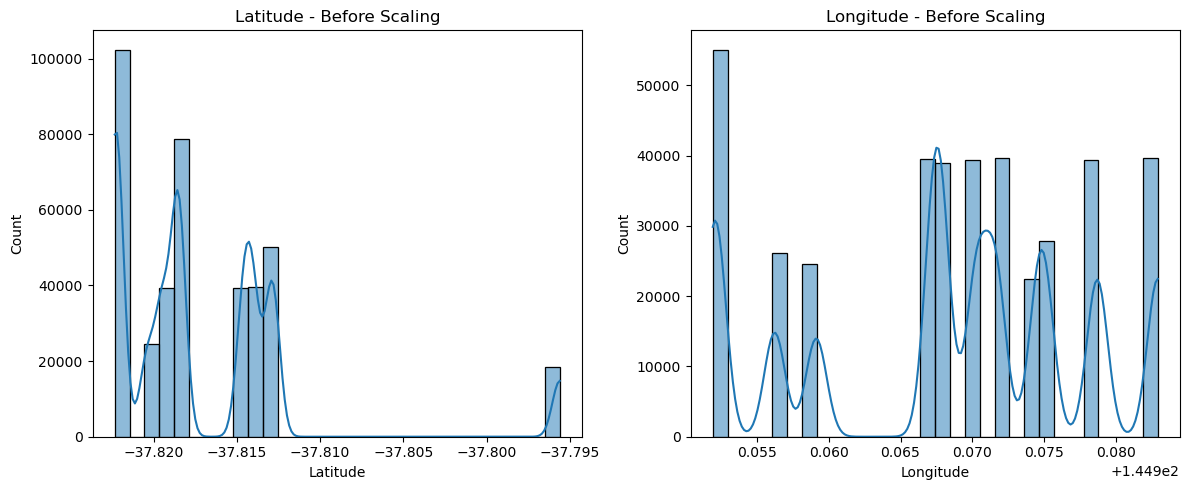

In [45]:

# --- Plot distribution before scaling ---
features_to_scale = ['Latitude', 'Longitude']

plt.figure(figsize=(12, 5))

# Plot Latitude
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['Latitude'], bins=30, kde=True)
plt.title('Latitude - Before Scaling')

# Plot Longitude
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['Longitude'], bins=30, kde=True)
plt.title('Longitude - Before Scaling')

plt.tight_layout()
plt.show()

# --- Apply Min-Max Scaling ---
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_cleaned[features_to_scale])

# Add scaled columns to DataFrame
df_cleaned['Latitude_scaled'] = scaled[:, 0]
df_cleaned['Longitude_scaled'] = scaled[:, 1]


### Min-Max Scaling Explanation

After extracting `Latitude` and `Longitude`, we applied **Min-Max Scaling** to normalize their values between 0 and 1.

This process involves transforming each value using the formula:  
```
X_scaled = (X - X_min) / (X_max - X_min)
```

**Purpose of Min-Max Scaling:**
- Ensures all features are on the same scale, especially important for algorithms that rely on distance or gradient descent.
- Prevents features with large numeric ranges from dominating the learning process.
- Maintains the original shape of the distribution while shrinking the scale.

**Observations from Distribution Plots:**
- Before scaling: Latitude and Longitude had their natural range values.
- After scaling: Values are rescaled between 0 and 1, but the overall distribution shape remains the same.

This makes the dataset more consistent and suitable for machine learning models.


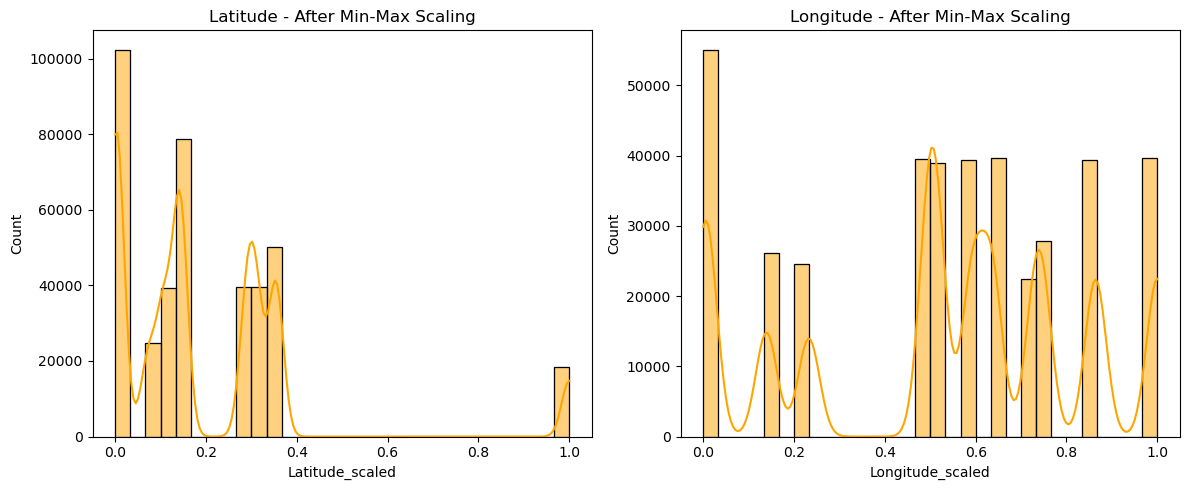

In [46]:

# --- Plot distribution after scaling ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['Latitude_scaled'], bins=30, kde=True, color='orange')
plt.title('Latitude - After Min-Max Scaling')

plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['Longitude_scaled'], bins=30, kde=True, color='orange')
plt.title('Longitude - After Min-Max Scaling')

plt.tight_layout()
plt.show()


### Distribution Before and After Scaling

The plots above compare the distribution of `Latitude` and `Longitude` before and after applying **Min-Max Scaling**.

#### Key Observations:
- **Before scaling**: The values were in their original range, specific to geographic coordinates.
- **After scaling**: All values were rescaled between 0 and 1, using the formula:
  ```
  X_scaled = (X - X_min) / (X_max - X_min)
  ```
- **No change in distribution shape**: While the scale is normalized, the histogram retains the original distribution pattern (e.g., skewness, peaks, and spread).


### Conclusion

- Missing values were addressed using **mean** or **median** imputation based on feature skewness.
- **Median** was chosen for strongly skewed features to reduce the impact of outliers.
- **Mean** was applied to features with roughly symmetric distributions for accurate central tendency representation.
- The `LatLong` feature was split into separate **Latitude** and **Longitude** numeric columns to preserve spatial information.
- **Min-Max scaling** was applied to continuous features to normalize values between 0 and 1, improving model performance.
- These preprocessing steps ensured the dataset was cleaner, more consistent, and ready for effective machine learning modeling.
